In [124]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.autograd import Variable

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [125]:
cuda = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if cuda:
    torch.cuda.manual_seed(125)

In [126]:
data = pd.read_csv("../data/SBUX.csv")

data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
data["Volume"] = data["Volume"].astype(float)
print(data.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [127]:
x = data.iloc[:, :-1]
y = data.iloc[:, 5:6]

In [128]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

x_train = x_ss[:200, :]
x_test = x_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Train Shape: ", x_train.shape, y_train.shape)
print("Test Shape: ", x_test.shape, y_test.shape)

Train Shape:  (200, 5) (200, 1)
Test Shape:  (53, 5) (53, 1)


In [129]:
x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

x_train_tensors_f = torch.reshape(x_train_tensors, (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_f = torch.reshape(x_test_tensors, (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))

In [130]:
class GRUModel(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super().__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(
            torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        )
        out, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [131]:
num_epochs = 1000
learning_rate = 0.01

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1

model = GRUModel(num_classes, input_size, hidden_size, num_layers, x_train_tensors_f.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [132]:
for epoch in range(num_epochs):
    outputs = model(x_train_tensors_f.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors.to(device))
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, Loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, Loss: 0.15693
Epoch: 100, Loss: 0.02367
Epoch: 200, Loss: 0.02279
Epoch: 300, Loss: 0.02230
Epoch: 400, Loss: 0.02189
Epoch: 500, Loss: 0.02153
Epoch: 600, Loss: 0.02121
Epoch: 700, Loss: 0.02093
Epoch: 800, Loss: 0.02069
Epoch: 900, Loss: 0.02047


In [133]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = torch.Tensor(df_x_ss)
df_y_ms = torch.Tensor(df_y_ms)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

In [134]:
train_predict = model(df_x_ss.to(device))
predicted = train_predict.cpu().data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

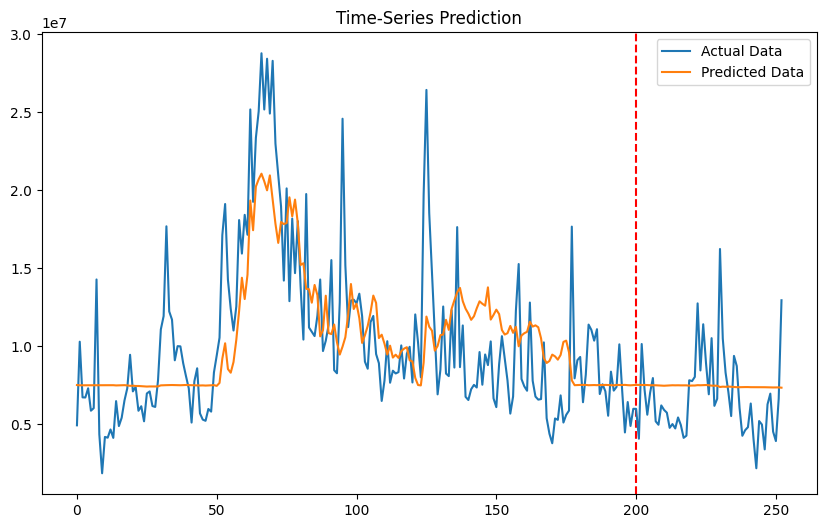

In [135]:
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c="r", linestyle="--")

plt.plot(label_y, label="Actual Data")
plt.plot(predicted, label="Predicted Data")
plt.title("Time-Series Prediction")
plt.legend()
plt.show()